In [31]:
import yfinance as yf
import pandas as pd
import datetime
from statistics import mean
import matplotlib.pyplot as plt #pyplot package under the matplotlib package
import seaborn as sns
%matplotlib inline 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
ticker = yf.Ticker("1211.hk")

# set user input parameters

In [4]:
risk_free_rate = 0.02

In [5]:
market_return_rate = 0.1

In [8]:
cap_growth = 1.20

In [9]:
current_year = "2022"

# Custom functions 

In [10]:
def clean_dataframe(frame):
    frame = frame.T.rename_axis('year').reset_index()
    frame["year"] = pd.DatetimeIndex(frame["year"]).year
    frame = frame.sort_values(by=['year'], ascending=False)
    frame.fillna(0, inplace=True)
    return frame

In [11]:
def get_DCF_value(history):
    #create empty growth list
    growth_history = []
    
    #calculate the growth between each year. add to the list
    for i in range(0,(len(ocf_history)-1)):
        growth = (history[i] - history[i+1]) / abs(history[i+1])    
        growth_history.append(growth)
    
    #get the average growth
    average_growth_rate = 1 + mean(growth_history)
    
    #for year 4-10, if average growth in year 1-3 is more than 15%, cap it at 15%
    if average_growth_rate > cap_growth: 
        average_growth_rate_cap = cap_growth
    else: 
        average_growth_rate_cap = average_growth_rate
        
    #project future cash flow (loop properly)
    future_value = []
    start_value = history[0]
    for i in range(1, 11):
        #for year 1 - 3, grow by average growth rate
        if i <= 3:
            value =  start_value * average_growth_rate
            future_value.append(value)
            start_value = value
        #for year 4-10, grow by cap growth rate
        elif i > 3:
            value =  start_value * average_growth_rate_cap
            future_value.append(value)
            start_value = value

    # convert future values into present value and sum them
    present_value = 0 

    for i in range(0, len(future_value)):
        value = future_value[i] / pow(wacc, (i+1))
        present_value += value
    
    #calculate present value per share
    fair_value = present_value/shares
    
    return fair_value

In [12]:
def perpetual_growth_valuation(history):
    growth_history = []
    
    #calculate the growth between each year. add to the list
    for i in range(0,(len(history)-1)):
        growth = (history[i] - history[i+1]) / abs(history[i+1])    
        growth_history.append(growth)

    #get the minimum growth
    min_growth_rate = 1 + min(growth_history)

    #bring to current year and then project for next year. assuming we missed this year's payment
    next_payment = history[0] * min_growth_rate * min_growth_rate 

    #apply formula
    valuation = next_payment / (wacc - min_growth_rate)
    return valuation

# Download fundementals

In [13]:
ticker.info.keys()

dict_keys(['sector', 'fullTimeEmployees', 'longBusinessSummary', 'city', 'phone', 'country', 'companyOfficers', 'website', 'maxAge', 'address1', 'industry', 'address2', 'ebitdaMargins', 'profitMargins', 'grossMargins', 'operatingCashflow', 'revenueGrowth', 'operatingMargins', 'ebitda', 'targetLowPrice', 'recommendationKey', 'grossProfits', 'freeCashflow', 'targetMedianPrice', 'currentPrice', 'earningsGrowth', 'currentRatio', 'returnOnAssets', 'numberOfAnalystOpinions', 'targetMeanPrice', 'debtToEquity', 'returnOnEquity', 'targetHighPrice', 'totalCash', 'totalDebt', 'totalRevenue', 'totalCashPerShare', 'financialCurrency', 'revenuePerShare', 'quickRatio', 'recommendationMean', 'exchange', 'shortName', 'longName', 'exchangeTimezoneName', 'exchangeTimezoneShortName', 'isEsgPopulated', 'gmtOffSetMilliseconds', 'quoteType', 'symbol', 'messageBoardId', 'market', 'annualHoldingsTurnover', 'enterpriseToRevenue', 'beta3Year', 'enterpriseToEbitda', '52WeekChange', 'morningStarRiskRating', 'forwa

In [14]:
shares = ticker.info["sharesOutstanding"]
market_cap = ticker.info["marketCap"]
beta = ticker.info["beta"]


In [15]:
ticker.info["longBusinessSummary"]

"BYD Company Limited, together with its subsidiaries, engages in the research, development, manufacture, and sale of automobiles and related products in the People's Republic of China and internationally. It operates through three segments: Rechargeable Batteries and Photovoltaic Products; Mobile Handset Components, Assembly Service and Other Products; and Automobiles and Related Products and Other Products. The company offers internal combustion, hybrid, and battery-electric passenger vehicles; buses, coaches, and taxis; logistics, construction, and sanitation vehicles; and vehicles for warehousing, port, airport, and mining operations. It also manufactures and sells lithium-ion and nickel batteries, photovoltaic products, and iron batteries primarily for mobile phones, electric tools, and other portable electronic instruments; mobile handset components, such as housings and electronic components; medical protection products; and automobiles, and auto-related molds and components, as 

# download and clean statements

In [16]:
## income statement 
IS = ticker.financials
IS = clean_dataframe(IS)

## balance sheet
BS = ticker.balance_sheet
BS = clean_dataframe(BS)

## cashflow statement
CF = ticker.cashflow
CF = clean_dataframe(CF)

## combined  dataset
df = pd.merge(IS, BS, on="year")
df = df.merge(CF, on= "year")
df["year"] = df['year'].astype(str)

In [17]:
#create total debt column
debt_types = ["Short Long Term Debt","Long Term Debt"] 
df["total_debt"] = 0

for i in debt_types:
    if (i in df.columns) == True:
        df["total_debt"]  += df[i]

In [18]:
#free cash flow
df["FCF"]= df['Total Cash From Operating Activities'] + df['Capital Expenditures']

In [19]:
#Return on Equity
df["ROE"] = df["Net Income Applicable To Common Shares"] / df["Total Stockholder Equity"]

In [20]:
#current ratio
df['current_ratio'] = df['Total Current Assets'] / df['Total Current Liabilities']

In [21]:
#debt_to_equity
df["debt_to_equity"] = df["total_debt"] / df['Total Stockholder Equity']

# Charts 

In [22]:
axis = list(df["year"])
axis = sorted(axis)
axis

['2018', '2019', '2020', '2021']

## cashflows

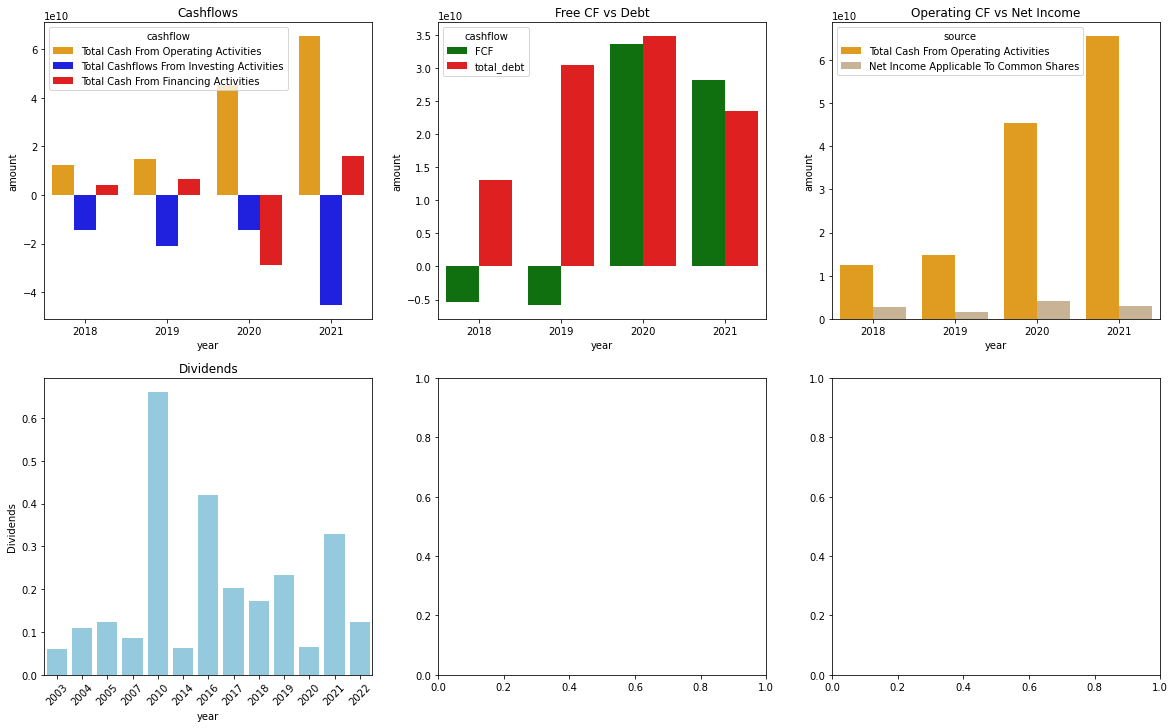

In [42]:
fig, axes = plt.subplots(2, 3,figsize=(20,12))


cashflow_df = df[["year","Total Cash From Operating Activities","Total Cashflows From Investing Activities", "Total Cash From Financing Activities"]]
cashflow_df = cashflow_df.melt(id_vars="year",var_name="cashflow",value_name="amount")
sns.barplot("year", "amount", data=cashflow_df, hue = "cashflow", palette = ["orange", "blue", "red"], order=axis, ax=axes[0,0])
axes[0,0].set(title="Cashflows")

fcf_df = df[["year","FCF", "total_debt"]]
fcf_df = fcf_df.melt(id_vars="year",var_name="cashflow",value_name="amount")
sns.barplot("year", "amount", data=fcf_df, hue = "cashflow", palette = ["green", "red"], order=axis, ax=axes[0,1])
axes[0,1].set(title="Free CF vs Debt")

cashflow_income= df[["year","Total Cash From Operating Activities",'Net Income Applicable To Common Shares']]
cashflow_income = cashflow_income.melt(id_vars="year",var_name="source",value_name="amount")
sns.barplot("year", "amount", data=cashflow_income, hue = "source", palette = ["orange", "tan"], order=axis,ax=axes[0,2])
axes[0,2].set(title="Operating CF vs Net Income")


#dividends already adjusted for stock split according to yahoo finance
dividend_history = ticker.actions
dividend_history = dividend_history.rename_axis('year').reset_index()
dividend_history["year"] = pd.DatetimeIndex(dividend_history["year"]).year
dividend_history = dividend_history[dividend_history["Stock Splits"]==0]
dividend_history = dividend_history[["year", "Dividends"]]
dividend_history = dividend_history.groupby("year").sum()

if len(dividend_history)>0:
    sns.barplot("year", "Dividends", data=dividend_history.reset_index(), color = "skyblue", ax=axes[1,0])
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].set(title="Dividends")
else:
    sns.barplot(x = axis, y=[0] * len(axis) ,color = "skyblue", ax=axes[1,0])
    axes[1,0].tick_params(axis='x', rotation=45)   
    axes[1,0].set(title="Dividends")

## balancesheet

[Text(0.5, 1.0, 'Current Ratio and Debt to Equity')]

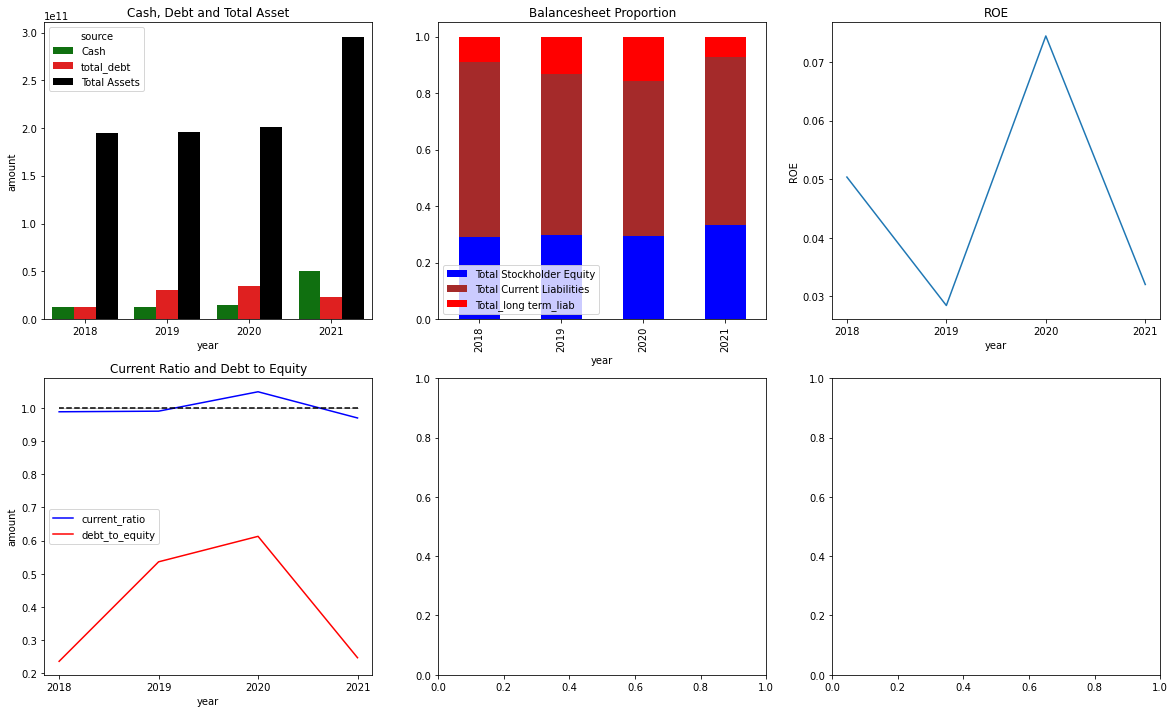

In [43]:
fig2, axes = plt.subplots(2, 3,figsize=(20,12))

balancesheet_prop= df[["year",'Cash', "total_debt", 'Total Assets']]
balancesheet_prop = balancesheet_prop.melt(id_vars="year",var_name="source",value_name="amount")
sns.barplot("year", "amount", data=balancesheet_prop, hue = "source", palette = ["green", "red", 'black', "black"], order=axis,ax=axes[0,0])
axes[0,0].set(title="Cash, Debt and Total Asset")

balancesheet_df = BS[["year",'Total Stockholder Equity','Total Current Liabilities','Total Liab']]
balancesheet_df["Total_long term_liab"] = balancesheet_df["Total Liab"] - balancesheet_df["Total Current Liabilities"] 
balancesheet_df.drop("Total Liab",axis="columns", inplace =True)
balancesheet_df = balancesheet_df.set_index("year").sort_index()
balancesheet_df = balancesheet_df.div(balancesheet_df.sum(axis=1), axis=0)
balancesheet_df.plot(kind='bar', stacked=True, color=['blue', 'brown', 'red'], ax=axes[0,1])
axes[0,1].set(title="Balancesheet Proportion")

sns.lineplot(df["year"], df["ROE"], ax=axes[0,2])
axes[0,2].invert_xaxis()
axes[0,2].set(title="ROE")

bs_ratio_df = df[["year","current_ratio", "debt_to_equity"]]
bs_ratio_df = bs_ratio_df.melt(id_vars="year",var_name="ratio",value_name="amount")
sns.lineplot(bs_ratio_df["year"], bs_ratio_df["amount"],hue=bs_ratio_df["ratio"], palette=["blue", "red"], ax=axes[1,0])
sns.lineplot(bs_ratio_df["year"], 1, color = "black", linestyle="--", ax=axes[1,0])
axes[1,0].invert_xaxis()
axes[1,0].set(title="Current Ratio and Debt to Equity")

# WACC calculations

## Extract lates year data

In [44]:
latest_year = df.iloc[0]

## debt section 

In [45]:
debt = latest_year["total_debt"]

total_wacc_value = debt + market_cap
total_wacc_value

debt_weight = debt/total_wacc_value

if abs(latest_year['Interest Expense']) != 0 and debt!=0:
    debt_cost = abs(latest_year['Interest Expense']) / debt
elif abs(latest_year['Interest Expense']) == 0 and debt==0:
    debt_cost = 0
elif abs(latest_year['Interest Expense']) != 0 and debt==0:
    debt_cost = 0

tax_rate = latest_year['Income Tax Expense'] / latest_year['Income Before Tax']

In [46]:
total_wacc_value

854471487568.0

## equity section

In [47]:
# beta = 1

In [48]:
beta

0.490539

In [49]:
equity_weight =  market_cap/total_wacc_value

equity_cost = risk_free_rate +  beta*(market_return_rate-risk_free_rate)
equity_cost

0.059243119999999996

## WACC

In [50]:
wacc = ((equity_weight * equity_cost) + (debt_weight * debt_cost * (1-tax_rate))) + 1
wacc

1.0595724609316726

# Discounted Growth Model

## a) Cashflow

In [51]:
# averge growth rate
ocf_history = list(df['Total Cash From Operating Activities'])
get_DCF_value(ocf_history)

4722.052090481176

## b) Income

In [52]:
ic_history = list(df['Net Income Applicable To Common Shares'])
get_DCF_value(ic_history)

74.75139504553393

## c) Free Cash Flow

In [53]:
fcf_history = list(df["FCF"])
get_DCF_value(fcf_history)

8943.822996853098

# Dividend Discount Model 

## a) perpetual dividend growth 

In [54]:
#get the only completed years with all dividends paid out. Company with fiscal year at the start of year still haven't 
#completed dividend pay out for the year
dividend_year = []
if axis[-1] == current_year:
    for i in range(0, len(axis)): 
        dividend_year.append(int(axis[i])-1)
        print(dividend_year[i])
else: 
    dividend_year = [int(year) for year in axis]

In [55]:
if len(dividend_history)>0:
    #filter the last 4 years of dividends payment
    dividend_history = dividend_history[dividend_history.index.isin(dividend_year)]
    dividend_history = dividend_history.sort_index(ascending=False)
    dividend_history = list(dividend_history["Dividends"])
    DDM_valuation = perpetual_growth_valuation(dividend_history)
else: 
    DDM_valuation = 0
 
print("past 4 complete yearly dividend payout are: ", dividend_history)
print("DDM valuations is: ", DDM_valuation)

past 4 complete yearly dividend payout are:  [0.32788, 0.06562, 0.23216, 0.17248]
DDM valuations is:  0.03371590747867008


### b) perpetual FCF growth

In [56]:
perpetual_growth_valuation(fcf_history)/shares

80.36135127129528

# Other matrixes

In [57]:
book_value = ticker.info["bookValue"]
book_value

33.249

In [58]:
PE_ratio = ticker.info["trailingPE"]
PE_ratio

106.23255

In [59]:
ticker.info["trailingPegRatio"]

1.2995

In [60]:
ticker.info["payoutRatio"]

0.0558

# Analyst's recommendations

In [211]:
ticker.recommendations["To Grade"].value_counts().head(8)

Buy               42
Neutral           32
Overweight        24
Outperform        21
Hold              20
Equal-Weight      10
Market Perform     9
Sell               3
Name: To Grade, dtype: int64

# Development area

## cashflows

In [40]:
# axis = list(df["year"])
# axis = sorted(axis)
# axis

In [41]:
# cashflow_df = df[["year","Total Cash From Operating Activities","Total Cashflows From Investing Activities", "Total Cash From Financing Activities"]]
# cashflow_df = cashflow_df.melt(id_vars="year",var_name="cashflow",value_name="amount")
# sns.barplot("year", "amount", data=cashflow_df, hue = "cashflow", palette = ["orange", "blue", "red"], order=axis)

In [42]:
# fcf_df = df[["year","FCF", "total_debt"]]
# fcf_df = fcf_df.melt(id_vars="year",var_name="cashflow",value_name="amount")
# sns.barplot("year", "amount", data=fcf_df, hue = "cashflow", palette = ["green", "red"], order=axis)

In [43]:
# cashflow_income= df[["year","Total Cash From Operating Activities",'Net Income Applicable To Common Shares']]
# cashflow_income = cashflow_income.melt(id_vars="year",var_name="source",value_name="amount")
# sns.barplot("year", "amount", data=cashflow_income, hue = "source", palette = ["orange", "tan"], order=axis)

## balance sheet

In [44]:
# balancesheet_prop= df[["year",'Cash', "total_debt", 'Total Assets']]
# balancesheet_prop = balancesheet_prop.melt(id_vars="year",var_name="source",value_name="amount")
# sns.barplot("year", "amount", data=balancesheet_prop, hue = "source", palette = ["green", "red", 'black', "black"], order=axis)

In [45]:
# balancesheet_df = BS[["year",'Total Stockholder Equity','Total Current Liabilities','Total Liab']]
# balancesheet_df["Total_long term_liab"] = balancesheet_df["Total Liab"] - balancesheet_df["Total Current Liabilities"] 
# balancesheet_df.drop("Total Liab",axis="columns", inplace =True)
# balancesheet_df = balancesheet_df.set_index("year").sort_index()
# balancesheet_df = balancesheet_df.div(balancesheet_df.sum(axis=1), axis=0)
# balancesheet_df.plot(kind='bar', stacked=True, color=['blue', 'brown', 'red'])

In [46]:
# ax = sns.lineplot(df["year"], df["ROE"])
# ax.invert_xaxis()
# ax.set(title="ROE")
# ax.legend()

In [47]:
# bs_ratio_df = df[["year","current_ratio", "debt_to_equity"]]
# bs_ratio_df = bs_ratio_df.melt(id_vars="year",var_name="ratio",value_name="amount")
# ax = sns.lineplot(bs_ratio_df["year"], bs_ratio_df["amount"],hue=bs_ratio_df["ratio"], palette=["blue", "red"])
# ax = sns.lineplot(bs_ratio_df["year"], 1, color = "black", linestyle="--")
# ax.invert_xaxis()
# ax.legend()